# ADAMS Final Task



# Importing Data

Our first step involves importing the data that we will begin training on. We have been provided with two training sets, each scrapped from the internet in a different way. Our goal in the coming sections will be to merge the two datasets so it more accurately reflects the test set.

## Reading in the Datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Stem words
import nltk
nltk.download('popular')
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# Remove stopwords
from nltk.corpus import stopwords

# Library beatifulsoup4 handles html
from bs4 import BeautifulSoup

from gensim.models.phrases import Phrases, Phraser
from gensim.models.word2vec import LineSentence

import pickle

import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin

from keras.initializers import Constant
from keras.layers import Dense, LSTM, Flatten, SpatialDropout1D, Dropout, Conv1D, GlobalMaxPooling1D, Bidirectional, CuDNNLSTM
from keras import metrics, optimizers

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

Using TensorFlow backend.


In [0]:
# read in datasets

df1 = pd.read_csv('Medium_AggregatedData.csv') # read in first dataset
df2 = pd.read_csv('articles.csv') # read in second dataset

In [0]:
print('Number of columns in train data 1:' + ' ' + str(len(df1.columns)))
print('Number of columns in train data 2:' + ' ' + str(len(df2.columns)))

Number of columns in train data 1: 50
Number of columns in train data 2: 6


As we can see, our datasets differing number of columns. This presents a challenge, as information may be present in our training data that won't be in our testing set. Therefore it makes sense to drop the columns from our training set that are not present in the test set. Additional processing includes, removing duplicate entries from the first dataset, selecting only English language articles and replacing the text representation of the number of claps with its numerical representation, ie *2.4K* will be written as *2400*.

In [0]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 100)
df1.head(5)

audioVersionDurationSec codeBlock  codeBlockCount  collectionId  \
0                        0       NaN             0.0  638f418c8464   
1                        0       NaN             0.0  638f418c8464   
2                        0       NaN             0.0  638f418c8464   
3                        0       NaN             0.0           NaN   
4                        0       NaN             0.0           NaN   

  createdDate      createdDatetime firstPublishedDate firstPublishedDatetime  \
0  2018-09-18  2018-09-18 20:55:34         2018-09-18    2018-09-18 20:57:03   
1  2018-09-18  2018-09-18 20:55:34         2018-09-18    2018-09-18 20:57:03   
2  2018-09-18  2018-09-18 20:55:34         2018-09-18    2018-09-18 20:57:03   
3  2018-01-07  2018-01-07 17:04:37         2018-01-07    2018-01-07 17:06:29   
4  2018-01-07  2018-01-07 17:04:37         2018-01-07    2018-01-07 17:06:29   

   imageCount  isSubscriptionLocked language latestPublishedDate  \
0           1                 False       en          2018-09-18   
1           1                 False       en          2018-09-18   
2           1                 False       en          2018-09-18   
3          13                 False       en          2018-01-07   
4          13                 False       en          2018-01-07   

  latestPublishedDatetime  linksCount        postId  readingTime  recommends  \
0     2018-09-18 20:58:20           1  10007d3018fe     0.958491           2   
1     2018-09-18 20:58:20           1  10007d3018fe     0.958491           2   
2     2018-09-18 20:58:20           1  10007d3018fe     0.958491           2   
3     2018-01-07 17:18:38          24  1000c43bcb97    19.716981           0   
4     2018-01-07 17:18:38          24  1000c43bcb97    19.716981           0   

   responsesCreatedCount  socialRecommendsCount  \
0                      0                      0   
1                      0                      0   
2                      0                      0   
3                      0                      0   
4                      0                      0   

                                                                                              subTitle  \
0  A major private IT company implements blockchain, artificial intelligence, and Internet of Thing...   
1  A major private IT company implements blockchain, artificial intelligence, and Internet of Thing...   
2  A major private IT company implements blockchain, artificial intelligence, and Internet of Thing...   
3                                                                                         Introduction   
4                                                                                         Introduction   

   tagsCount  \
0          5   
1          5   
2          5   
3          5   
4          5   

                                                                                                  text  \
0  Private Business, Government and Blockchain\n\nA major private IT company implements blockchain,...   
1  Private Business, Government and Blockchain\n\nA major private IT company implements blockchain,...   
2  Private Business, Government and Blockchain\n\nA major private IT company implements blockchain,...   
3  EPQ draft 1 (4844 words)\nhttps://upload.wikimedia.org/wikipedia/commons/1/1f/Sanko_Seisakusyo_%...   
4  EPQ draft 1 (4844 words)\nhttps://upload.wikimedia.org/wikipedia/commons/1/1f/Sanko_Seisakusyo_%...   

                                         title  totalClapCount  \
0  Private Business, Government and Blockchain             100   
1  Private Business, Government and Blockchain             100   
2  Private Business, Government and Blockchain             100   
3                     EPQ draft 1 (4844 words)               0   
4                     EPQ draft 1 (4844 words)               0   

                                                uniqueSlug updatedDate  \
0  private-business-government-and-blockchain-10007d3018fe  20

In [0]:
df2.head(3)

author claps  reading_time  \
0        Justin Lee  8.3K            11   
1       Conor Dewey  1.4K             7   
2  William Koehrsen  2.8K            11   

                                                                                                  link  \
0  https://medium.com/swlh/chatbots-were-the-next-big-thing-what-happened-5fc49dd6fa61?source=-----...   
1  https://towardsdatascience.com/python-for-data-science-8-concepts-you-may-have-forgotten-i-did-8...   
2  https://towardsdatascience.com/automated-feature-engineering-in-python-99baf11cc219?source=-----...   

                                                                     title  \
0  Chatbots were the next big thing: what happened? – The Startup – Medium   
1               Python for Data Science: 8 Concepts You May Have Forgotten   
2           Automated Feature Engineering in Python – Towards Data Science   

                                                                                                  text  
0  Oh, how the headlines blared:\nChatbots were The Next Big Thing.\nOur hopes were sky high. Brigh...  
1  If you’ve ever found yourself looking up the same question, concept, or syntax over and over aga...  
2  Machine learning is increasingly moving from hand-designed models to automatically optimized pip...

In [0]:
#remove duplicate postIds that are present due to different tags 
df1_filter = df1.drop_duplicates('postId')

#remove non-english articles
df1_filter = df1_filter.loc[df1_filter['language'] == 'en', :]


In [0]:
#columns to keep from first dataframe
col = ['author', 'totalClapCount', 'readingTime', 'url', 'text']
df1_filter = df1_filter[col]

In [0]:
df1_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66380 entries, 0 to 279572
Data columns (total 5 columns):
author            66380 non-null object
totalClapCount    66380 non-null int64
readingTime       66380 non-null float64
url               66380 non-null object
text              66380 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 3.0+ MB


In [0]:
# combine title and text column together into one column
df2['text'] = df2['title'].fillna('') + ' ' + df2['text'].fillna('')

# drop title column
df2 = df2.drop(['title'], axis = 1)

df2.head()

author claps  reading_time  \
0        Justin Lee  8.3K            11   
1       Conor Dewey  1.4K             7   
2  William Koehrsen  2.8K            11   
3      Gant Laborde  1.3K             7   
4  Emmanuel Ameisen   935            11   

                                                                                                  link  \
0  https://medium.com/swlh/chatbots-were-the-next-big-thing-what-happened-5fc49dd6fa61?source=-----...   
1  https://towardsdatascience.com/python-for-data-science-8-concepts-you-may-have-forgotten-i-did-8...   
2  https://towardsdatascience.com/automated-feature-engineering-in-python-99baf11cc219?source=-----...   
3  https://medium.freecodecamp.org/machine-learning-how-to-go-from-zero-to-hero-40e26f8aa6da?source...   
4  https://blog.insightdatascience.com/reinforcement-learning-from-scratch-819b65f074d8?source=----...   

                                                                                                  text  
0  Chatbots were the next big thing: what happened? – The Startup – Medium Oh, how the headlines bl...  
1  Python for Data Science: 8 Concepts You May Have Forgotten If you’ve ever found yourself looking...  
2  Automated Feature Engineering in Python – Towards Data Science Machine learning is increasingly ...  
3  Machine Learning: how to go from Zero to Hero – freeCodeCamp If your understanding of A.I. and M...  
4  Reinforcement Learning from scratch – Insight Data Want to learn about applied Artificial Intell...

In [0]:
# convert k to 000's so we have a number instad of text 
df2.claps = (df2.claps.replace(r'[KM]+$', '', regex=True).astype(float) * # remove K or M from number and leave the float 
             df2.claps.str.extract(r'[\d\.]+([KM]+)', expand=False)       # extract the K or M from the number
             .fillna(1)                                                   # any number that doesn't have K or M gets a 1
             .replace(['K','M'], [10**3, 10**6]).astype(int))             # replace K or M with 1000 or 1000000, respectively and multiply

print(df2.claps[0:5])

0    8300.0
1    1400.0
2    2800.0
3    1300.0
4     935.0
Name: claps, dtype: float64


In [0]:
# give both dataframes the same names
df1_filter.columns = df2.columns

# append the second dataframe to the first one
df1_filter = df1_filter.append(df2)


In [0]:
# reset index 
df1_filter = df1_filter.reset_index(drop = True)

df1_filter.tail(3)

author   claps  reading_time  \
66714       Devin Soni  5800.0           4.0   
66715  Carlos E. Perez  3900.0           7.0   
66716  Nityesh Agarwal  2400.0          13.0   

                                                                                                      link  \
66714  https://towardsdatascience.com/spiking-neural-networks-the-next-generation-of-machine-learning-8...   
66715  https://medium.com/intuitionmachine/neurons-are-more-complex-than-what-we-have-imagined-b3dd00a1...   
66716  https://towardsdatascience.com/wth-does-a-neural-network-even-learn-a-newcomers-dilemma-bd8d1bbb...   

                                                                                                      text  
66714  Spiking Neural Networks, the Next Generation of Machine Learning Everyone who has been remotely ...  
66715  Surprise! Neurons are Now More Complex than We Thought!! One of the biggest misconceptions aroun...  
66716  “WTH does a neural network even learn??” — a newcomer’s dilemma I believe, we all have that psyc...

In [0]:
def clean_article1(X):
    X = X.apply(lambda x: " ".join(x.lower() for x in x.split())) #turn all words to lowercase
    
        
    #remove html content
    X = X.apply(lambda x: BeautifulSoup(x, "html.parser").get_text())
    
    import re

    def clean_str(s):
        s = re.sub(r"\'s", " is", s) # replace 's with is
        s = re.sub(r"\'ve", " have", s) #replace 've with have
        s = re.sub(r"n\'t", " not", s) #replace 've with a blank space
        s = re.sub(r"http\S+", ' ', s) # replace urls with blank space
        s = re.sub(r"[^a-z \-]", " ", s) # remove all characters that are not alpha
        s = re.sub(r"[\-]", "", s) # replace hyphens to join words
        s = re.sub(r"\b[a-zA-Z]\b", " ", s) # remove any one letter words
        s = re.sub(r"\s{2,}", " ", s) # replace any extra spaces with one space
        return s.strip()
    
    X = X.apply(clean_str) #apply the text cleaning function to begin the preprocessing
    
    return X

In [0]:
#apply our preprocessing function to our train reviews
df1_filter['clean_text'] = clean_article1(df1_filter['text'])
df1_filter['clean_text'].head()

C:\Users\Haseeb\Anaconda3\envs\deeplearning\lib\site-packages\bs4\__init__.py:335: UserWarning: "https://icoratingblog.wordpress.com/2017/12/07/ico-rating-2/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\Haseeb\Anaconda3\envs\deeplearning\lib\site-packages\bs4\__init__.py:335: UserWarning: "https://icoratingblog.wordpress.com/2017/12/05/first-blog-post/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\Haseeb\Anaconda3\envs\deeplearning\lib\site-packages\bs4\__init__.py:335: UserWarning: "https://blog.juecell.in/2018/08/artificial-intelligence-living-with.html?m=1" looks like a URL. Be

0    private business government and blockchain major private it company implements blockchain artifi...
1    epq draft words introduction automation is set to unemploy people at scale and rate never seen b...
2    ascent of data science sas and big data analyst trainings programs various associations in the p...
3    can robot love us better than another human can discussed this with michelle tsng on my podcast ...
4    big data ai and iot use cases an active list of interesting use cases mentioned in class image s...
Name: clean_text, dtype: object

In [0]:
from gensim.models.phrases import Phrases, Phraser

# tokenized_train = [t.split(' ') for t in df1_filter['clean_text']] #split sentences into tokens
# phrases = Phrases(tokenized_train, min_count = 10)  # train model
# bigram = Phraser(phrases) #find bigrams
# bigram.save('bigrams_all')
    
# load the finished model from disk
bigram = Phrases.load('/content/drive/My Drive/ADAMS(FINAL)/bigrams_all')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def clean_article2(X):
    
    #add bigrams to corpus from bigram model
    X = X.apply(lambda x: ' '.join(bigram[x.split(' ')]))
    
        
    # define our stopwords
    stop = set(stopwords.words('english'))
    
    X = X.apply(lambda x: " ".join(x for x in x.split() if x not in stop)) # remove stopwords
    
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)
    
    lemmatizer = WordNetLemmatizer()
  
    #stem each word 
    X = X.apply(lambda x: " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(x)]))
          
    return X

In [0]:
#apply our preprocessing function to our train reviews
df1_filter['clean_text'] = clean_article2(df1_filter['clean_text'])
df1_filter['clean_text']

0        private business government blockchain major private company implement blockchain artificial_int...
1        epq draft word introduction automation set unemploy people scale rate never_seen while_simultane...
2        ascent data_science sa big data analyst training program various association present day opening...
3        robot love u well another human discuss michelle tsng podcast crazy wisdom she_says robot love u...
4        big data ai iot use_cases active list interest use_cases mention class image source randstad art...
5        artificial_intelligence next_frontier company already consider integrate artificial_intelligence...
6        aidoc get ce_mark deep_learning solution aidoc lead ai startup utilize deep_learning augment rad...
7        ai impact world actually ai efiicting world good way efficient way though gon na kill different ...
8        meta model meta_metamodel deep_learning credit inception model deep_learning consists computatio...
9        top tip da

In [0]:
#df1_filter.to_csv('cleaned_articles_lemma2.csv', header = True, index = False, sep = ',')

In [0]:
df1_filter = pd.read_csv('/content/drive/My Drive/ADAMS(FINAL)/cleaned_articles_lemma2.csv')

We now have a combined dataset, that we are ready to do some exploratory data analysis on.

# Exploratory Data Analysis

Firstly, let's look at the overall distribution of the number of claps an article has received, and then group that by author to see if certain authors are more popular than others.

In [0]:
df1_filter['clean_text'] = df1_filter['clean_text'].fillna('')

The majority of the articles actually didn't receive any claps, and only a handful were extremely popular with readers. We can further break this down by author to see if certain authors are more popular than others.

In [0]:
# get summary statistics for number of claps grouped by authors
author_grouped = df1_filter.groupby('author').agg(
    {'claps': ['mean', 'sum', 'max', 'min'], # summary stats for claps
     'link' : "count" # number of articles written by author
    }
    )
author_grouped.columns = ["_".join(x) for x in author_grouped.columns.ravel()] # change column names
author_grouped = author_grouped.sort_values('claps_max', ascending= False) # sort authors by average number of claps
author_grouped.head(20)

claps_mean  claps_sum  ...  claps_min  link_count
author                                                 ...                       
Zat Rana                      43883.555556   394952.0  ...     2734.0           9
Wil Wheaton                  200357.000000   200357.0  ...   200357.0           1
Jonathan Solórzano-Hamilton   56382.500000   112765.0  ...      170.0           2
Michael Simmons               51136.000000   153408.0  ...    24569.0           3
Lauren Hallden                79766.000000    79766.0  ...    79766.0           1
Daniel Colin James            67949.000000    67949.0  ...    67949.0           1
Adam Geitgey                  14819.875000   355677.0  ...     1855.0          24
Kai Stinchcombe               47235.666667   141707.0  ...    44000.0           3
Sophia Ciocca                 53000.000000   106000.0  ...    53000.0           2
Xiaohan Zeng                  48612.666667   145838.0  ...    48000.0           3
TK                            47445.000000    47445.0  ...    47445.0           1
Addy Osmani                   46490.000000    46490.0  ...    46490.0           1
Michael Jordan                37058.250000   148233.0  ...    34000.0           4
Daniel Jeffries                9536.500000    76292.0  ...      219.0           8
Anything App                  42710.000000    42710.0  ...    42710.0           1
Jeff Kao                      41280.000000    41280.0  ...    41280.0           1
Stefan Kojouharov              8309.333333    99712.0  ...        6.0          12
Radu Raicea                   39376.000000    39376.0  ...    39376.0           1
Andrej Karpathy               18414.666667   110488.0  ...     9200.0           6
Charlie Jeppsson              38255.000000    38255.0  ...    38255.0           1

[20 rows x 5 columns]

        count_words          claps
count  66717.000000   66717.000000
mean     466.192275     199.568776
std      429.053409    2028.513582
min        0.000000       0.000000
25%      215.000000       0.000000
50%      367.000000       6.000000
75%      586.000000      66.000000
90%      899.000000     255.000000
95%     1181.000000     574.000000
99%     2017.840000    2941.200000
max    12051.000000  291706.000000


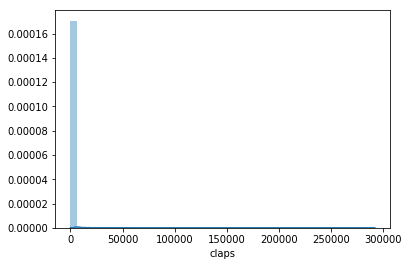

In [0]:
# code taken and adapeted from following website: https://towardsdatascience.com/sentiment-analysis-with-text-mining-13dd2b33de27

class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, text):
        return len(re.findall(pattern, text))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        
        df = pd.DataFrame({'count_words': count_words
                           })
        
        return df
    
tc = TextCounts()
df_eda = tc.fit_transform(df1_filter['clean_text'])
df_eda['claps'] = df1_filter.claps
print(df_eda.describe([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
sns.distplot(df1_filter['claps'])

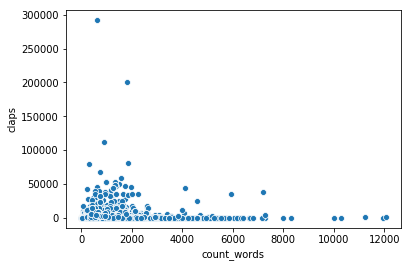

In [0]:

ax = sns.scatterplot(x="count_words", y="claps", data=df_eda)

In [0]:
df_eda['log_claps'] = df_eda['claps'].apply(lambda x: np.log(x + 0.01)) 


        count_words          claps     log_claps
count  66717.000000   66717.000000  66717.000000
mean     466.192275     199.568776      0.854950
std      429.053409    2028.513582      4.085139
min        0.000000       0.000000     -4.605170
25%      215.000000       0.000000     -4.605170
50%      367.000000       6.000000      1.793425
75%      586.000000      66.000000      4.189806
90%      899.000000     255.000000      5.541303
95%     1181.000000     574.000000      6.352647
99%     2017.840000    2941.200000      7.986576
max    12051.000000  291706.000000     12.583502


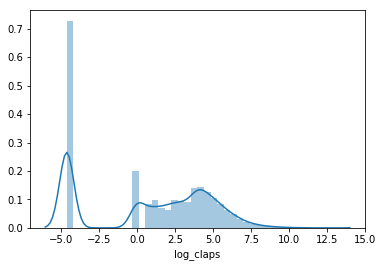

In [0]:
print(df_eda.describe([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
sns.distplot(df_eda['log_claps'])

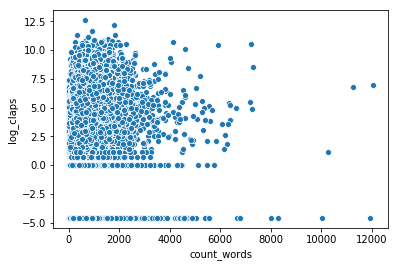

In [0]:
ax = sns.scatterplot(x="count_words", y="log_claps", data=df_eda)

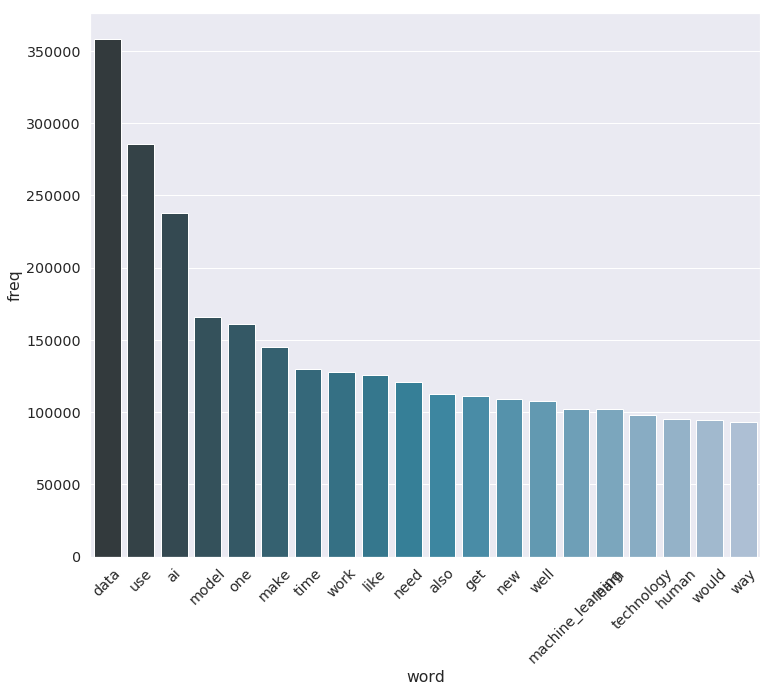

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import collections

sns.set(style="darkgrid")
sns.set(font_scale=1.3)

cv = CountVectorizer()
bow = cv.fit_transform(df1_filter['clean_text'])
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show();

In [0]:
final_df = pd.concat([df1_filter, df_eda[['count_words', 'log_claps']]], axis = 1, sort = False)
print('Number of reviews including 0 claps:', len(final_df))
final_df = final_df[(final_df['claps'] >= 1) & (final_df['claps'] <= 100000)]
print('Number of reviews excluding 0 claps:', len(final_df))
final_df.head(3)

Number of reviews including 0 claps: 66717
Number of reviews excluding 0 claps: 45856


author  claps  ...  count_words log_claps
0    Anar Babaev  100.0  ...           95  4.605270
3  Stewart Alsop   50.0  ...           87  3.912223
4   Melody Ucros   27.0  ...          986  3.296207

[3 rows x 8 columns]

              claps  reading_time   count_words     log_claps
count  45856.000000  45856.000000  45856.000000  45856.000000
mean     277.171406      4.538911    522.296384      3.337795
std     1720.579649      3.698167    446.159268      2.132253
min        1.000000      0.003774      0.000000      0.009950
25%        5.000000      2.324528    257.000000      1.611436
50%       36.000000      3.683019    418.000000      3.583797
75%      124.000000      5.662736    652.000000      4.820362
90%      402.000000      8.406604    987.000000      5.996477
95%      838.250000     10.785220   1280.000000      6.731328
99%     4285.400000     17.937217   2155.900000      8.362971
max    80886.000000     99.603774  12051.000000     11.300796


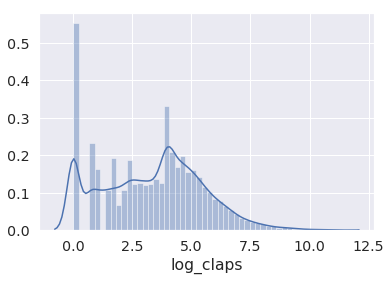

In [0]:
print(final_df.describe([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
sns.distplot(final_df['log_claps'])

In [0]:
seed = 111
X_train, X_test, y_train, y_test = train_test_split(final_df[['clean_text', 'count_words']], final_df['claps'], test_size=0.25, random_state=seed)



## Baseline

We will look at a simple linear regression model as our baseline to compare to. In order to use our text data, we must first apply a *TF-IDF* transformation to our documents. Essentitally, the words in our documents will be converted into a score and our documents will be converted into a vector using those scores. By applying this transformation we get an extremely large and sparse matrix. Computation time can be an issue with such a large amount of features, so we will be using an SGDRegressor from the *scikitlearn* library.   

In [0]:
vectorizer = TfidfVectorizer()

vectorizer.fit(X_train['clean_text'])

X_train_tfidf = vectorizer.transform(X_train['clean_text'])
X_test_tfidf  = vectorizer.transform(X_test['clean_text'])

In [0]:
from sklearn.linear_model import SGDRegressor
import time
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

model = SGDRegressor(loss='squared_loss', penalty='none', random_state=seed)
start = time.time()
model.fit(X_train_tfidf, y_train)
end = time.time()
print('Time to train model: %0.2fs' % (end -start))


Time to train model: 73.86s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [0]:
print(model.score(X_train_tfidf, y_train))
print(model.score(X_test_tfidf, y_test))

from sklearn.metrics import mean_squared_error
y_preds = model.predict(X_test_tfidf)

print('MSE for TF-IDF method: ' , mean_squared_error(y_test, y_preds))

0.2978634106557446
0.09630888239922819
MSE for TF-IDF method:  4069387.268440043


## Word Embeddings

Moving past simple representations of words, we will now look at embeddings. Embeddings 

In [0]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

d2v = Doc2Vec.load("/content/drive/My Drive/ADAMS(FINAL)/doc2vec")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# from gensim.models import Word2Vec    

d2v_tokens = X_train['clean_text'].apply(lambda x: word_tokenize(x))

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(d2v_tokens)]
embedding_size = 300

documents[0]
# Train a Word2Vec model
# w2v = Word2Vec(w2v_tokens, 
#                  min_count=5,## min_count means the frequency benchmark, if =2 and word is used only once - it's not included
#                  window=5, #the size of context
#                  iter =50, #how many times the training code will run through the data set, same as epochs (first pass is to create dict)
#                  size=embedding_size, #size of embedding
#                  workers=3)#for parallel computing
# # summarize the loaded model
# print(w2v)


TaggedDocument(words=['hacker', 'launch', 'ico', 'imagine', 'data', 'really', 'act', 'its_own', 'well', 'imagine', 'thermostat', 'room', 'hospital', 'communicate', 'patient_health', 'record', 'current', 'health', 'reading', 'equipment', 'find', 'optimal', 'room_temperature', 'humidity', 'patient', 'thought', 'blockchain', 'startup', 'base', 'harrisburg', 'pennsylvania', 'work', 'ai', 'smart', 'data', 'know', 'importance', 'great', 'team', 'put_together', 'skillful', 'development', 'team', 'well', 'accomplish', 'board', 'advisor', 'certainly', 'try', 'hide', 'thought', 'fundamentally_changing', 'way', 'data', 'process', 'embed', 'every', 'piece', 'data', 'artificial_intelligence', 'mean', 'otherwise', 'dumb', 'data', 'need', 'application', 'become', 'useful', 'becomes', 'valuable', 'smart', 'able', 'act', 'its_own', 'understand', 'come', 'suppose', 'go', 'reduces', 'need', 'thirdparty', 'application', 'make', 'data', 'processing', 'lot', 'cheaper', 'faster', 'amount', 'data', 'create', 

In [0]:
# Init the Doc2Vec model
# d2v = Doc2Vec(documents, vector_size=embedding_size, min_count=2, epochs=50, workers=4)

In [0]:
# d2v.save('doc2vec')


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# from google.colab import files
# files.download('doc2vec')
# files.download('doc2vec.trainables.syn1neg.npy')
# files.download('doc2vec.wv.vectors.npy')

In [0]:
# w2v_embs="w2v_embeddingsfull2.txt"
# w2v.wv.save_word2vec_format(w2v_embs, binary=False)
# w2v.save("word2vec_3.model")

C:\Users\Haseeb\Anaconda3\envs\deeplearning\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\Haseeb\Anaconda3\envs\deeplearning\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
d2v_test_tokens = X_test['clean_text'].apply(lambda x: word_tokenize(x))

In [0]:
[d2v.infer_vector(x) for x in d2v_test_tokens]

[array([-1.42399897e-03, -2.44636345e+00,  1.90714800e+00, -3.53102952e-01,
         6.27838850e-01, -1.45256841e+00, -1.43561468e-01, -1.43258297e+00,
        -2.15060210e+00,  3.22915822e-01, -1.04778087e+00,  1.30908048e+00,
        -7.93481708e-01, -3.19522500e-01, -2.11963964e+00, -6.82987452e-01,
         4.21666414e-01,  1.91823411e+00,  4.59551692e-01, -1.11989629e+00,
        -6.20178580e-01, -7.97781587e-01,  1.59369636e+00,  1.22199965e+00,
         1.98795009e+00,  9.99194562e-01,  1.10322642e+00, -1.38371634e+00,
         1.74537361e+00,  2.24429917e+00,  3.56640592e-02,  1.79503453e+00,
         2.39876723e+00, -7.72802651e-01, -8.87265384e-01,  1.92429602e+00,
         6.77266002e-01, -7.69226730e-01,  1.29674959e+00, -2.76023006e+00,
         1.54916787e+00, -3.04304266e+00,  1.86560404e+00,  9.75397527e-01,
        -2.01046562e+00, -1.48752344e+00, -2.42665577e+00,  5.25918067e-01,
        -6.31614625e-01, -7.27814198e-01,  2.02336293e-02, -1.86463785e+00,
        -1.7

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_length = 5000
tk = Tokenizer(filters='') #, num_words=NB_WORDS
tk.fit_on_texts(w2v_tokens)

In [0]:
MAX_NB_WORDS = len(word_vectors.vocab) #size of vocabulary

word_index = tk.word_index
vocab_size = len(tk.word_index) + 1
print('Found %s unique tokens.' % len(word_index))

embedding_matrix = np.zeros((MAX_NB_WORDS, embedding_size)) #create our embedding matrix and match our tokens with the output from Word2Vec

for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    except:
        pass 

Found 311565 unique tokens.


In [0]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28754413, -0.39047846, -1.75719142, ..., -0.16324389,
        -0.96047968,  1.25764799],
       [-1.18431056, -0.947505  ,  1.20426679, ..., -0.38336164,
         0.89523727, -0.37516367],
       ...,
       [-0.54825145,  0.14851402, -0.1472699 , ...,  0.04003013,
        -0.38967401,  0.04034124],
       [ 0.05744703,  0.02066173, -0.04796725, ...,  0.13033225,
        -0.14102297, -0.19000351],
       [ 0.31892651, -0.11431462, -0.10240069, ...,  0.09409281,
        -0.29645076, -0.23296206]])

In [0]:
X_train_tokens = X_train['clean_text'].apply(lambda x: word_tokenize(x))
X_test_tokens = X_test['clean_text'].apply(lambda x: word_tokenize(x))

print(X_train_tokens.head())

X_seq = tk.texts_to_sequences(X_train_tokens)
X_pad = pad_sequences(X_seq, maxlen=max_length, padding='post')


X_seq_test = tk.texts_to_sequences(X_test_tokens)
X_pad_test = pad_sequences(X_seq_test, maxlen=max_length, padding='post')


print(X_pad)
print(X_pad_test)

45405    [understand, principle_component, analysis, pa...
50286    [quick, implementation, yolo, kera, hold, owne...
1408     [ai, crypto, second, meetup, global, ico, seou...
9463     [tensorboard, hessian, matrix, linear_regressi...
44584    [chapter, data, different_types, machine_learn...
Name: clean_text, dtype: object
[[    48  17462    123 ...      0      0      0]
 [   920    539   3258 ...      0      0      0]
 [     3   1663    245 ...      0      0      0]
 ...
 [   751    160    334 ...      0      0      0]
 [   173    321    159 ...      0      0      0]
 [  1848   4788 145173 ...      0      0      0]]
[[ 4944 14623 78256 ...     0     0     0]
 [ 2773   180   180 ...     0     0     0]
 [ 3014  1753 21284 ...     0     0     0]
 ...
 [   67   913  1905 ...     0     0     0]
 [ 1087    15  4719 ...     0     0     0]
 [  420   316   505 ...     0     0     0]]


In [0]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [0]:
from keras.initializers import Constant
from keras.layers import Dense, LSTM, Flatten, SpatialDropout1D, Dropout, Conv1D, GlobalMaxPooling1D, Bidirectional, CuDNNLSTM
from keras import metrics, optimizers

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping

cnn = Sequential()
cnn.add(Embedding(vocab_size, embedding_size,
                    input_length = max_length,
                    embeddings_initializer = Constant(embedding_matrix),
                    trainable = False))
cnn.add(Conv1D(filters=250, kernel_size=2, padding='valid', activation='relu', strides=1))
cnn.add(GlobalMaxPooling1D())
cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.1))
cnn.add(Dense(256, activation='relu'))
cnn.add(Dense(1, activation='linear'))
cnn.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
cnn.summary()


W0808 11:21:21.264893 140697092446080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 11:21:21.322122 140697092446080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 11:21:28.430117 140697092446080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0808 11:21:28.523972 140697092446080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0808 11:21:28.531843 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5000, 300)         93469800  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4999, 250)         150250    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               128512    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total para

In [0]:


cb2=EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=4, restore_best_weights=True)

story_cnn = cnn.fit(X_pad, y_train, epochs=20, verbose=1, validation_data = (X_pad_test, y_test), callbacks=[cb2], batch_size=32)

Train on 18880 samples, validate on 6294 samples
Epoch 1/20
18880/18880 [==============================] - 29s 2ms/step - loss: 9559510.9799 - mean_squared_error: 9559510.9799 - mean_absolute_error: 616.1442 - val_loss: 9719618.1081 - val_mean_squared_error: 9719618.1081 - val_mean_absolute_error: 970.8820
Epoch 2/20
18880/18880 [==============================] - 29s 2ms/step - loss: 7373659.5297 - mean_squared_error: 7373659.5297 - mean_absolute_error: 577.9409 - val_loss: 8708064.7175 - val_mean_squared_error: 8708064.7175 - val_mean_absolute_error: 479.6037
Epoch 3/20
18880/18880 [==============================] - 29s 2ms/step - loss: 4307945.9823 - mean_squared_error: 4307945.9823 - mean_absolute_error: 517.0615 - val_loss: 8760548.5619 - val_mean_squared_error: 8760548.5619 - val_mean_absolute_error: 613.3654
Epoch 4/20
18880/18880 [==============================] - 30s 2ms/step - loss: 2114921.1075 - mean_squared_error: 2114921.1075 - mean_absolute_error: 471.5337 - val_loss: 103

In [0]:
score_cnn = cnn.evaluate(X_pad_test, y_test_log, verbose=0)

In [0]:
#cnn.save_weights('cnn_7.h5')

In [0]:
cnn_predict = cnn.predict(X_pad_test)

#cnn_predict = np.exp(cnn_predict_log)
print(cnn_predict)
print(mean_squared_error(y_test, cnn_predict))

[[382.41394]
 [563.6954 ]
 [250.22508]
 ...
 [317.00748]
 [155.44048]
 [216.9062 ]]
8708064.183802383


In [0]:
np.min(cnn_predict)

0.14121896

In [0]:
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model

main = Input(shape=(max_length,), dtype='int32')

x = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=max_length, embeddings_initializer = Constant(embedding_matrix),
                    trainable = False)(main)

bigram_branch = Conv1D(filters=250, kernel_size=2, padding='valid', activation='relu', strides=1)(x)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=250, kernel_size=3, padding='valid', activation='relu', strides=1)(x)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=250, kernel_size=4, padding='valid', activation='relu', strides=1)(x)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)

merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(512, activation='relu')(merged) #previous 256
merged = Dropout(0.1)(merged)
merged = Dense(256, activation='relu')(merged)
merged = Dense(1)(merged)
output = Activation('linear')(merged)

model = Model(inputs=[main], outputs=[output])
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5000)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 5000, 300)    93469800    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 4999, 250)    150250      embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 4998, 250)    225250      embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_4 (

In [0]:
cb=EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=3, restore_best_weights=True)
story_cnn_ngrams = model.fit(X_pad, y_train, epochs=10, verbose=1, validation_data = (X_pad_test, y_test), callbacks=[cb], batch_size=16)

W0808 11:22:50.477576 140697092446080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 34394 samples, validate on 11465 samples
Epoch 1/20
34394/34394 [==============================] - 215s 6ms/step - loss: 6442614.0527 - mean_squared_error: 6442614.0527 - mean_absolute_error: 391.8122 - val_loss: 4004643.8892 - val_mean_squared_error: 4004643.8892 - val_mean_absolute_error: 798.4192
Epoch 2/20
34394/34394 [==============================] - 202s 6ms/step - loss: 5919437.6962 - mean_squared_error: 5919437.6962 - mean_absolute_error: 384.8477 - val_loss: 3402598.6597 - val_mean_squared_error: 3402598.6597 - val_mean_absolute_error: 317.8663
Epoch 3/20
34394/34394 [==============================] - 203s 6ms/step - loss: 3972964.9658 - mean_squared_error: 3972964.9658 - mean_absolute_error: 366.4486 - val_loss: 3600247.8561 - val_mean_squared_error: 3600247.8561 - val_mean_absolute_error: 349.0728
Epoch 4/20
34394/34394 [==============================] - 204s 6ms/step - loss: 2149176.8203 - mean_squared_error: 2149176.8203 - mean_absolute_error: 348.1956 - val_loss

In [0]:
score_cnn_ngrams = model.evaluate(X_pad_test, y_test, verbose=0)

In [0]:
#model.save_weights('cnnbig_8.h5')

In [0]:
cnn_predict = model.predict(X_pad_test)

#cnn_predict = np.exp(cnn_predict_log)
print(cnn_predict)
print(mean_squared_error(y_test, cnn_predict))

[[169.23311]
 [100.79621]
 [104.08674]
 ...
 [146.33119]
 [113.4907 ]
 [163.71872]]
2625457.0083409436


In [0]:
from keras.layers import Dense, LSTM, Flatten, SpatialDropout1D, Dropout, Conv1D, GlobalMaxPooling1D, Bidirectional, CuDNNLSTM

lstm = Sequential()
lstm.add(Embedding(vocab_size, embedding_size,
                    input_length = max_length,
                    embeddings_initializer = Constant(embedding_matrix),
                    trainable = False))
#lstm.add(Bidirectional(CuDNNLSTM(64, return_sequences=True)))
lstm.add(Bidirectional(CuDNNLSTM(units = 64)))
lstm.add(Dense(1, activation='linear'))
lstm.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
lstm.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 5000, 300)         93469800  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               187392    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 93,657,321
Trainable params: 187,521
Non-trainable params: 93,469,800
_________________________________________________________________


In [0]:
story_lstm = lstm.fit(X_pad, y_train, epochs=5, verbose=1, validation_data = (X_pad_test, y_test), batch_size=16)

Train on 34394 samples, validate on 11465 samples
Epoch 1/5
34394/34394 [==============================] - 847s 25ms/step - loss: 6656855.1912 - mean_squared_error: 6656855.1912 - mean_absolute_error: 287.5944 - val_loss: 4041365.4465 - val_mean_squared_error: 4041365.4465 - val_mean_absolute_error: 312.7272
Epoch 2/5
34394/34394 [==============================] - 852s 25ms/step - loss: 6631771.3359 - mean_squared_error: 6631771.3359 - mean_absolute_error: 315.6428 - val_loss: 4027248.6781 - val_mean_squared_error: 4027248.6781 - val_mean_absolute_error: 333.1654
Epoch 3/5
34394/34394 [==============================] - 850s 25ms/step - loss: 6619812.4530 - mean_squared_error: 6619812.4530 - mean_absolute_error: 328.3064 - val_loss: 4013911.1738 - val_mean_squared_error: 4013911.1738 - val_mean_absolute_error: 351.8351
Epoch 4/5
34394/34394 [==============================] - 849s 25ms/step - loss: 6606493.8176 - mean_squared_error: 6606493.8176 - mean_absolute_error: 333.1811 - val_loss

In [0]:
score_lstm = lstm.evaluate(X_pad_test, y_test, verbose=0)

In [0]:
lstm_predict = lstm.predict(X_pad_test)

#cnn_predict = np.exp(cnn_predict_log)
print(lstm_predict)
print(mean_squared_error(y_test, lstm_predict))

[[131.26938]
 [134.81505]
 [278.0252 ]
 ...
 [246.55594]
 [280.10385]
 [138.60487]]
3997743.397354974


In [0]:
# lstm.save('lstm.h5')
# lstm.save_weights('lstm_weights.h5')

# submission

In [0]:
submission = pd.read_csv('/content/drive/My Drive/ADAMS(FINAL)/test.csv') # read in test dataset

In [0]:
submission = submission.drop(['Unnamed: 0'], axis = 1)
submission.head(3)

index  ... Length
0      0  ...  23401
1      1  ...  23972
2      2  ...    402

[3 rows x 7 columns]

In [0]:
submission['text'] = submission['Header'].fillna('') + ' ' + submission['Text'].fillna('')
submission.head()

index  ...                                               text
0      0  ...  Why Everyone Missed the Most Mind-Blowing Feat...
1      1  ...  NEO versus Ethereum: Why NEO might be 2018’s s...
2      2  ...  The Cryptocurrency Trading Bible So you want t...
3      5  ...  Stablecoins: designing a price-stable cryptocu...
4      7  ...  Chaos vs. Order — The Cryptocurrency Dilemma C...

[5 rows x 8 columns]

In [0]:
submission['clean_text'] = clean_article1(submission['text'])
submission['clean_text'] = clean_article1(submission['text'])
submission['clean_text'].head()

0    why everyone missed the most mindblowing featu...
1    neo versus ethereum why neo might be strongest...
2    the cryptocurrency trading bible so you want t...
3    stablecoins designing pricestable cryptocurren...
4    chaos vs order the cryptocurrency dilemma cryp...
Name: clean_text, dtype: object

In [0]:
X_submit_articles = submission['clean_text']
X_submit_tokens = X_submit_articles.apply(lambda x: word_tokenize(x))
X_submit_tokens.head(3)

0    [why, everyone, missed, the, most, mindblowing...
1    [neo, versus, ethereum, why, neo, might, be, s...
2    [the, cryptocurrency, trading, bible, so, you,...
Name: clean_text, dtype: object

In [0]:
X_seq_submit = tk.texts_to_sequences(X_submit_tokens) # turn tokens to numbers
X_pad_submit = pad_sequences(X_seq_submit, maxlen=max_length, padding='post') #pad sequences so they are the same length
print(X_pad_submit)

[[ 21460    500 228720 ...      0      0      0]
 [  4404   1966   2373 ...      0      0      0]
 [  1647   1154   7055 ...      0      0      0]
 ...
 [ 21460   1159   3367 ...      0      0      0]
 [  8311    301  44660 ...      0      0      0]
 [   121    301    152 ...      0      0      0]]


In [0]:
submission_pred = lstm.predict(X_pad_submit)

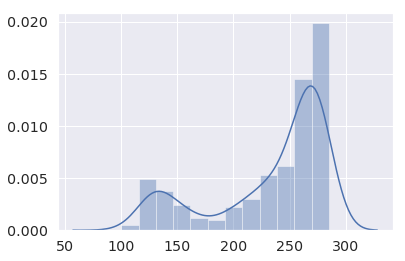

In [0]:
#submission_preds = np.exp(submission_pred)
submission_pred.mean()
sns.distplot(submission_pred)

In [0]:
temp_submit = pd.concat([submission, pd.DataFrame(submission_pred)], axis=1)
temp_submit.rename(columns={0:'Claps'}, inplace=True)
temp_submit.head(3)

index  ...       Claps
0      0  ...  280.189240
1      1  ...  279.566254
2      2  ...  273.456177

[3 rows x 10 columns]

In [0]:
final_submit = temp_submit[['index', 'Claps']]

final_submit.head(3)

index       Claps
0      0  280.189240
1      1  279.566254
2      2  273.456177

In [0]:
final_submit.to_csv('final_submit_lstm.csv', header = True, index = False, sep = ',')

In [0]:
from google.colab import files
files.download('doc2vec.trainables.syn1neg.npy')

In [0]:
!cp final_submit.csv drive/My\ Drive/ADAMS(FINAL)/

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `cp final_submit.csv drive/My\ Drive/ADAMS(FINAL)/'


In [0]:
df1_filter.loc[df1_filter['claps']>291000, 'text']

31666    Source\nThe Most Important Skill Nobody Taught...
Name: text, dtype: object